In [61]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns

In [63]:
#Load our dataframe account for the index columns
df = pd.read_csv('case_study.csv', index_col="Unnamed: 0")

In [64]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    display(x)
    pd.reset_option('display.max_rows')

In [7]:
df.shape

(34545, 255)

In [65]:
#Function to return the names of missing values based on a percentage answered.
def the_nans(dataframe, fill_perc):
    the_nans=[]
    threshold = dataframe.shape[0] * fill_perc / 100
    for column in dataframe.columns:
        if dataframe[column].isna().sum() >= dataframe[column].size - threshold:
            the_nans.append(column)
    return the_nans
#Saves the values of the dropped all nan columns into a variable and drops them out of the dataframe
removed_nans = the_nans(df, 0)
df.drop(columns=removed_nans, inplace=True)

#Matches states with it's key
def return_state_key(key):
    state_legend = {9: "Connecticut", 34: "New Jersey", 36: "New York"}
    return state_legend[key]

#Standardizes Interview Date and drops redundant columns
df["IDATE"] = df["IDATE"].map(lambda x: f"{str(x)[0:1]}-{str(x)[1:3]}-{str(x)[3:7]}"  if len(str(x)) == 7 else f"{str(x)[0:2]}-{str(x)[2:4]}-{str(x)[4:8]}")
df["IDATE"] = pd.to_datetime(df["IDATE"], format='%m-%d-%Y')
df.drop(columns=["IDAY", 'IMONTH', 'IYEAR'], inplace=True)

#Creates human readable state column:
df["STATE"] = df["_STATE"].map(lambda x: return_state_key(x))

In [66]:
#Data is already just those states.
df["_STATE"].unique()

array([ 9., 34., 36.])

In [67]:
#Numcodes for zero in Physhealth reconciled
df['PHYSHLTH'].replace({88:0}, inplace=True)

In [68]:
#Creates new categories to delete the dropped values.
pys_dropped_df = df.drop(df.loc[(df["PHYSHLTH"] == 99) | (df["PHYSHLTH"] == 77)].index)
pys_megadropped_df = df.drop(df.loc[(df["PHYSHLTH"] == 99) | (df["PHYSHLTH"] == 77) | (df["PHYSHLTH"] == 0)].index)
pys_drop_replaced_df = df.drop(df.loc[(df["PHYSHLTH"] == 99)].index).replace({77:pys_megadropped_df["PHYSHLTH"].median()})
pys_megadrop_replaced_df = df.drop(df.loc[(df["PHYSHLTH"] == 99) | (df["PHYSHLTH"] == 0)].index).replace({77:pys_megadropped_df["PHYSHLTH"].median()})

In [20]:
# pys_dropped_df['PHYSHLTH'].describe()
# pys_dropped_df['PHYSHLTH'].index

# type(pys_dropped_df["PHYSHLTH"])
# type(np.nan)

Int64Index([ 49938,  49939,  49940,  49941,  49942,  49943,  49944,  49945,
             49946,  49947,
            ...
            303769, 303770, 303771, 303772, 303773, 303774, 303775, 303776,
            303777, 303778],
           dtype='int64', length=33747)

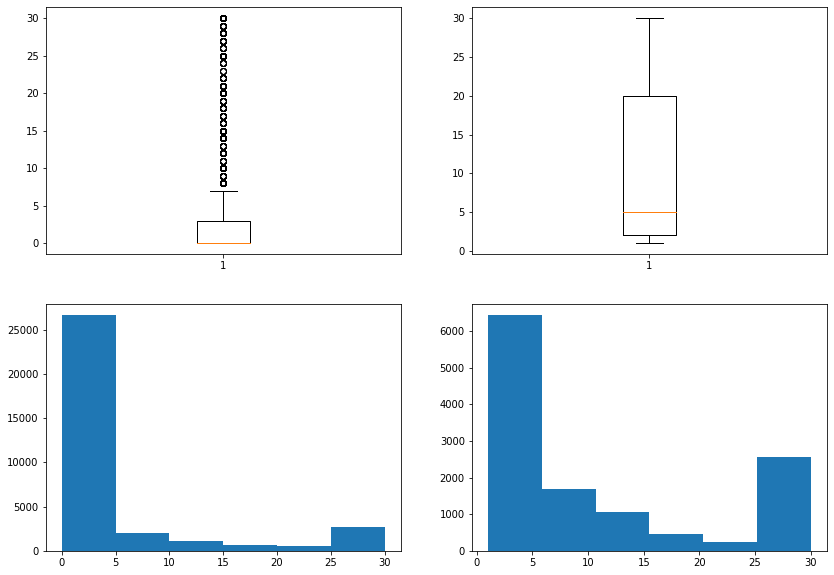

In [18]:
agg_fig = plt.figure(figsize=(14,10))
agg_ax1 = agg_fig.add_subplot(2,2,1)
agg_ax2 = agg_fig.add_subplot(2,2,2)
agg_ax3 = agg_fig.add_subplot(2,2,3)
agg_ax4 = agg_fig.add_subplot(2,2,4)
agg_ax1.boxplot(pys_dropped_df["PHYSHLTH"])
agg_ax2.boxplot(pys_megadropped_df["PHYSHLTH"])
agg_ax3.hist(pys_dropped_df["PHYSHLTH"], bins=6)
agg_ax4.hist(pys_megadropped_df["PHYSHLTH"], bins=6)
plt.show()

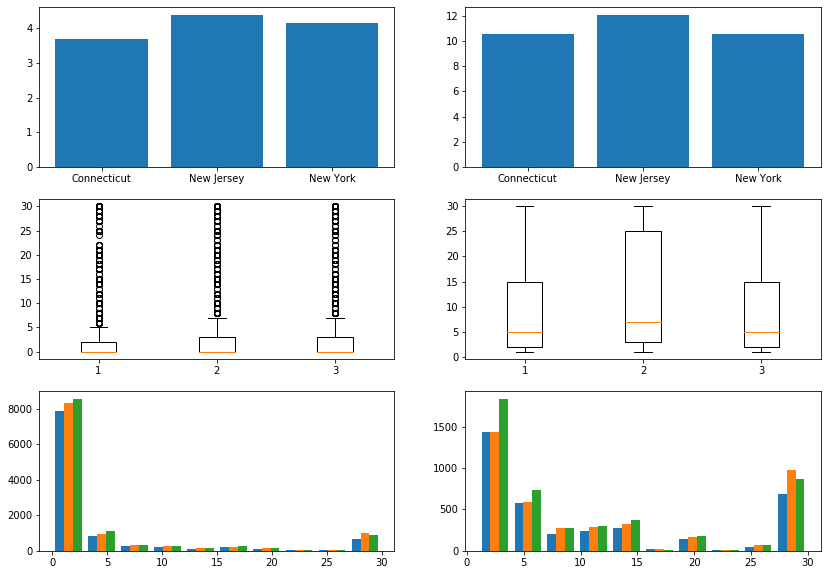

In [70]:

def state_divide(frame, key, val_list, show):
    func = lambda x: frame[show].loc[(frame[key] == x)]
    return [func(val) for val in val_list]
    
pys_dropped_df.groupby('STATE')['PHYSHLTH'].mean()
state_fig = plt.figure(figsize=(14,10))
state_ax1 = state_fig.add_subplot(3,2,1)
state_ax2 = state_fig.add_subplot(3,2,2)
state_ax3 = state_fig.add_subplot(3,2,3)
state_ax4 = state_fig.add_subplot(3,2,4)
state_ax5 = state_fig.add_subplot(3,2,5)
state_ax6 = state_fig.add_subplot(3,2,6)
state_ax1.bar(pys_dropped_df.groupby('STATE').mean().index, pys_dropped_df.groupby('STATE').mean()['PHYSHLTH'])
state_ax2.bar(pys_megadropped_df.groupby('STATE').mean().index, pys_megadropped_df.groupby('STATE').mean()['PHYSHLTH'])
state_ax3.boxplot(state_divide(pys_dropped_df, "_STATE", [9,34,36], "PHYSHLTH"))
state_ax4.boxplot(state_divide(pys_megadropped_df, "_STATE", [9,34,36], "PHYSHLTH"))
state_ax5.hist(state_divide(pys_dropped_df, "_STATE", [9,34,36], "PHYSHLTH"))
state_ax6.hist(state_divide(pys_megadropped_df, "_STATE", [9,34,36], "PHYSHLTH"))
plt.show()


In [11]:
pys_dropped_df.groupby('_STATE').mean().index

Float64Index([9.0, 34.0, 36.0], dtype='float64', name='_STATE')

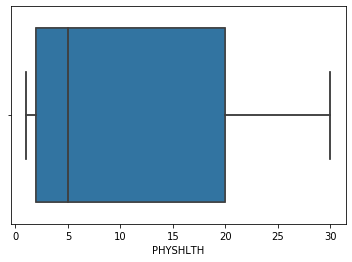

In [13]:
sns.boxplot(pys_megadropped_df["PHYSHLTH"])
sns.boxplot(pys_megadropped_df["PHYSHLTH"])

# pys_dropped_df["PHYSHLTH"].cou
# pys_dropped_df.iloc[:,0:15].info()
# pys_dropped_df["PHYSHLTH"]

In [71]:
pys_drop_replaced_df["CHRONIC"]= pys_drop_replaced_df["PHYSHLTH"]>=30
pys_megadrop_replaced_df["CHRONIC"]= pys_megadrop_replaced_df["PHYSHLTH"]>=30


In [72]:
chronically_grouped_full = pys_drop_replaced_df.groupby(["STATE"])["CHRONIC"]\
                                        .value_counts(normalize=True)\
                                        .rename("CHRONIC_PERC")\
                                        .mul(100)\
                                        .reset_index()
chronically_grouped = pys_megadrop_replaced_df.groupby(["STATE"])["CHRONIC"]\
                                        .value_counts(normalize=True)\
                                        .rename("CHRONIC_PERC")\
                                        .mul(100)\
                                        .reset_index()
chronically_grouped

,STATE,CHRONIC,CHRONIC_PERC
0,Connecticut,False,82.435659
1,Connecticut,True,17.564341
2,New Jersey,False,78.453797
3,New Jersey,True,21.546203
4,New York,False,82.635853
5,New York,True,17.364147


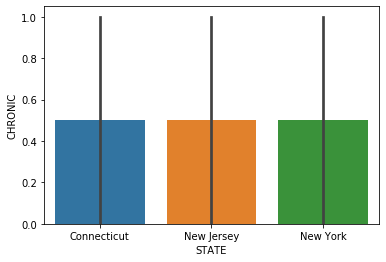

In [73]:
sns.barplot(x="STATE", y='CHRONIC', data=chronically_grouped )


In [29]:
pys_megadropped_df["PHYSHLTH"].describe()

count    12451.000000
mean        11.072846
std         10.911940
min          1.000000
25%          2.000000
50%          5.000000
75%         20.000000
max         30.000000
Name: PHYSHLTH, dtype: float64

In [73]:
df["_STATE"].unique()

array([ 9., 34., 36.])

In [86]:
type(df) == pd.core.frame.DataFrame

True

TypeError: '(['PHYSHLTH'], ['_STATE'])' is an invalid key